In [1]:
import os
import sys
sys.path.append(os.path.abspath('..'))

In [2]:
import torch
import torch.nn as nn
import numpy as np
import time
import datetime
import wandb
import gc
import pandas as pd
from train_helper import train_fn, valid_fn
from config import TrainConfig
from utils import get_logger, get_scheduler, load_pkl, weight_init, save_pkl
from dltime.data.ts_datasets import Soil_Dataset
from dltime.models.inception_atten import TSInceptionSelfAttnEncoderClassifier
from dltime.models.conv_atten import TSTransformerEncoderConvClassifier
from transformers import AdamW
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.utils import shuffle
from data_process import handle_dataset_3dims

/home/shizhaoshu/.conda/envs/torch111/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
CFG = TrainConfig()

In [4]:
# data process
data_for_train = ['zwy', 'zwy2', 'zwy3', 'zwy4']
train_data = []
for data_name in data_for_train:
    train_data.extend(load_pkl(f'./pickle_data/{data_name}_train.pkl'))

train_x, train_label = handle_dataset_3dims(train_data, mode="all")
train_x = np.swapaxes(train_x, 2, 1)
print('Train data size:', train_x.shape, train_label.shape)

train_dataset = Soil_Dataset(train_x, train_label, normalize=None, channel_first=True)
train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=True)

Train data size: (4672, 48, 5) (4672,)


In [9]:
model = TSInceptionSelfAttnEncoderClassifier(
        feat_dim=5, 
        max_len=64, 
        d_model=512, 
        num_heads=4,
        num_layers=4,
        dim_feedforward=None,
        num_classes=3)

model.load_state_dict(torch.load('./outputs/zwy_2022-05-30 15.11.pth', map_location='cpu'))

<All keys matched successfully>

In [6]:
model.eval()
preds = []
start = end = time.time()
for step, item in enumerate(train_loader):
    for k, v in item.items():
        item[k] = v.to(CFG.device)

    labels = item['label']
    batch_size = labels.size(0)
    with torch.no_grad():
        y_preds = model(item['input'])

    preds.append(y_preds.cpu().numpy())

predictions = np.concatenate(preds)

In [20]:
from torchcam.methods import CAM

In [21]:
for n, p in model.named_parameters():
    print(n, p.size())

project_inp.weight torch.Size([512, 5, 1])
encoder.0.self_attn.wq.0.bottleneck.conv1d.weight torch.Size([32, 512, 1])
encoder.0.self_attn.wq.0.convs.0.conv1d.weight torch.Size([32, 32, 39])
encoder.0.self_attn.wq.0.convs.1.conv1d.weight torch.Size([32, 32, 19])
encoder.0.self_attn.wq.0.convs.2.conv1d.weight torch.Size([32, 32, 9])
encoder.0.self_attn.wq.0.maxconvpool.1.conv1d.weight torch.Size([32, 512, 1])
encoder.0.self_attn.wq.0.bn.weight torch.Size([128])
encoder.0.self_attn.wq.0.bn.bias torch.Size([128])
encoder.0.self_attn.wq.1.bottleneck.conv1d.weight torch.Size([32, 512, 1])
encoder.0.self_attn.wq.1.convs.0.conv1d.weight torch.Size([32, 32, 39])
encoder.0.self_attn.wq.1.convs.1.conv1d.weight torch.Size([32, 32, 19])
encoder.0.self_attn.wq.1.convs.2.conv1d.weight torch.Size([32, 32, 9])
encoder.0.self_attn.wq.1.maxconvpool.1.conv1d.weight torch.Size([32, 512, 1])
encoder.0.self_attn.wq.1.bn.weight torch.Size([128])
encoder.0.self_attn.wq.1.bn.bias torch.Size([128])
encoder.0.sel

In [22]:
input_tensor = train_dataset[0]['input'].unsqueeze(0).to(CFG.device)
print(input_tensor.size())
with torch.no_grad():
    out = model(input_tensor)
print(out.size())

torch.Size([1, 5, 48])
torch.Size([1, 3])


In [31]:
from torchvision.models import resnet18
resnet_model = resnet18(pretrained=True).eval()

In [32]:
for n, p in resnet_model.named_parameters():
    print(n, p.size())

conv1.weight torch.Size([64, 3, 7, 7])
bn1.weight torch.Size([64])
bn1.bias torch.Size([64])
layer1.0.conv1.weight torch.Size([64, 64, 3, 3])
layer1.0.bn1.weight torch.Size([64])
layer1.0.bn1.bias torch.Size([64])
layer1.0.conv2.weight torch.Size([64, 64, 3, 3])
layer1.0.bn2.weight torch.Size([64])
layer1.0.bn2.bias torch.Size([64])
layer1.1.conv1.weight torch.Size([64, 64, 3, 3])
layer1.1.bn1.weight torch.Size([64])
layer1.1.bn1.bias torch.Size([64])
layer1.1.conv2.weight torch.Size([64, 64, 3, 3])
layer1.1.bn2.weight torch.Size([64])
layer1.1.bn2.bias torch.Size([64])
layer2.0.conv1.weight torch.Size([128, 64, 3, 3])
layer2.0.bn1.weight torch.Size([128])
layer2.0.bn1.bias torch.Size([128])
layer2.0.conv2.weight torch.Size([128, 128, 3, 3])
layer2.0.bn2.weight torch.Size([128])
layer2.0.bn2.bias torch.Size([128])
layer2.0.downsample.0.weight torch.Size([128, 64, 1, 1])
layer2.0.downsample.1.weight torch.Size([128])
layer2.0.downsample.1.bias torch.Size([128])
layer2.1.conv1.weight tor

In [47]:
submodule_dict = dict(model.named_modules())

In [118]:
feature_map = []     # 建立列表容器，用于盛放输出特征图

def forward_hook(module, inp, outp):     # 定义hook
    feature_map.append(outp)    # 把输出装入字典feature_map

submodule_dict['encoder.3'].register_forward_hook(forward_hook)    # 对net.layer4这一层注册前向传播

In [151]:
train_label[1000]

0

In [152]:
input_tensor = train_dataset[1000]['input'].unsqueeze(0).to(CFG.device)
print(input_tensor.size())
with torch.no_grad():
    out = model(input_tensor)


torch.Size([1, 5, 48])


In [153]:
cls = torch.argmax(out).item()    # 获取预测类别编码
weights = model._modules.get('output_layer').weight.data[cls,:]    # 获取类别对应的权重
cls

2

In [154]:
cam = (weights.view(*weights.shape, 1) * feature_map[-1].squeeze(0)).sum(0)

In [155]:
def _normalize(cams: torch.Tensor) -> torch.Tensor:
    """CAM normalization"""
    cams.sub_(cams.min(-1).values.unsqueeze(-1))
    cams.div_(cams.max(-1).values.unsqueeze(-1))

    return cams

In [156]:
import torch.nn.functional as F
cam = _normalize(F.relu(cam, inplace=True)).cpu()

In [157]:
cam

tensor([0.2237, 0.2936, 0.4886, 0.7308, 0.8698, 1.0000, 0.9020, 0.8356, 0.7292,
        0.2068, 0.0000, 0.0000, 0.0000, 0.0000, 0.1051, 0.8495, 0.7358, 0.7450,
        0.7773, 0.5643, 0.2474, 0.0596, 0.2529, 0.5394, 0.5452, 0.8111, 0.8342,
        0.8991, 0.7621, 0.6251, 0.4595, 0.2754, 0.0528, 0.0299, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0280, 0.0000, 0.0000, 0.0000, 0.0719, 0.0318, 0.0000,
        0.0000, 0.0000, 0.0942])

In [158]:
from data_process import plot_time

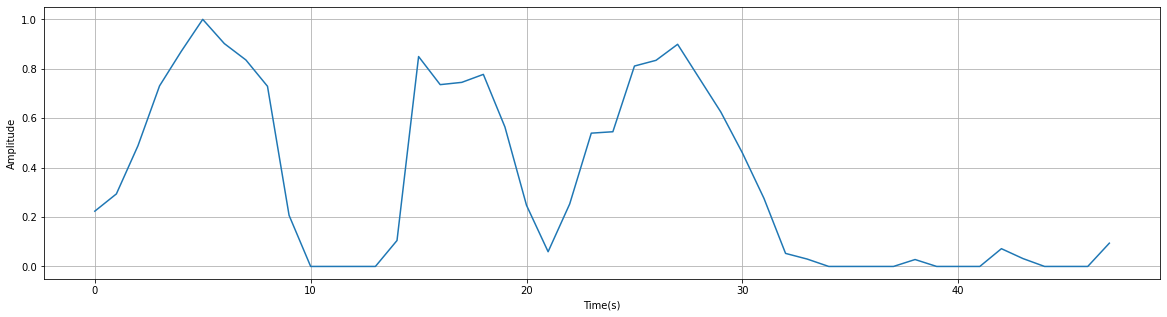

In [159]:
plot_time(cam)

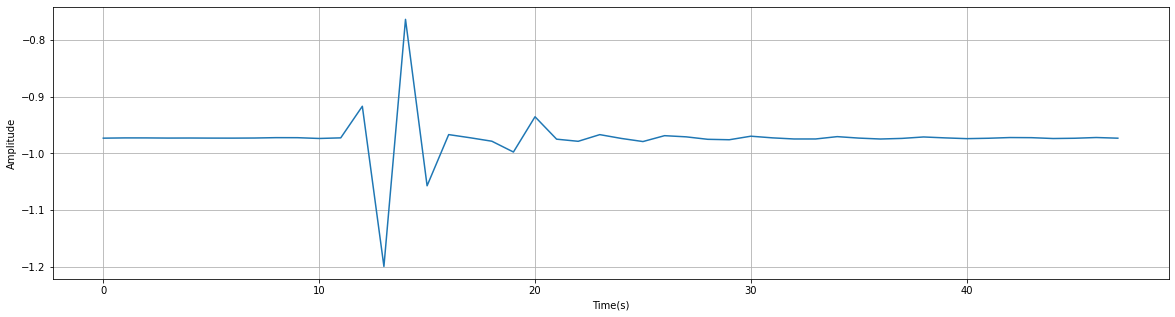

In [160]:
plot_time(train_data[1000]['data_z'])